In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

plt.style.use("~/evanstyle.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [2]:
toproot = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/"
topdirs = {5:toproot+"Run5/", 6:toproot+"Run6/", 7:toproot+"Run7/", 8:toproot+"Run8/", 9:toproot+"Run9/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])



/g/g15/angelico/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [3]:
#load data into mem if you want
for n, ana in anas.items():
    if(n==5 or n == 6): continue
    ana.load_dataframe()

# Get coincidence events and then plot separately

In [55]:
#choose which run to use
ana = anas[7]

#get the sampling time for the software channels. You can use the config file
#but for the moment I'm hard coding it.
dT = {0:1.0/125, 1:1.0/125, 2:1, 3:1, 4:1.0/125}

d = ana.df
d = d[~d["ch3 charge"].isna()]
#select charge event mask for which to qualify coincidences with
mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0) & (np.abs(d["ch3 charge"]) > 1)

d = d[mask]


#coincidence info
time_ref_ch = 3 #software channel for which to look for coincidences of
coinc = 0
coinc_ns = 0.3e9 
event_dfs = ana.get_coincidence(d, time_ref_ch, coinc, coinc_ns)


In [57]:
#get waveforms from waveform files, based on each event dataframe
wave_events = []
#channels of interest
chs_to_plot = [0,1,2,3]
for ev_df in event_dfs:
    wave_events.append(ana.get_waveforms_from_df(ev_df, chs_to_plot))

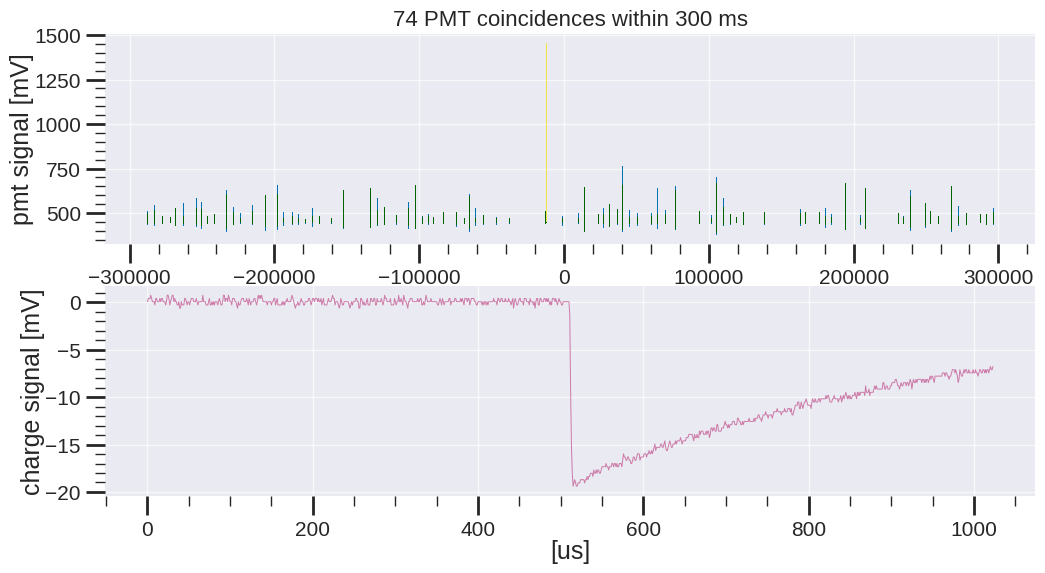

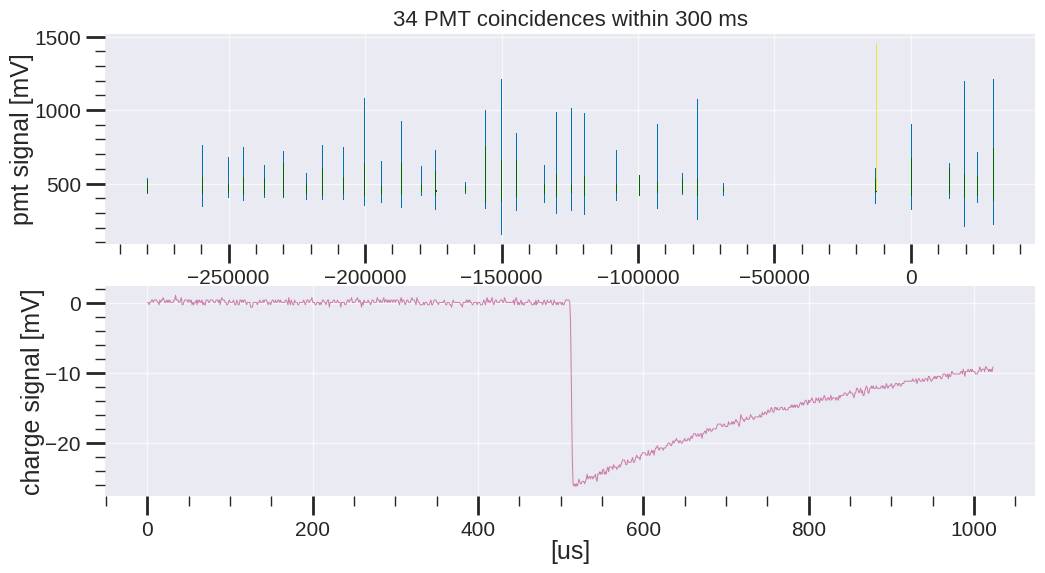

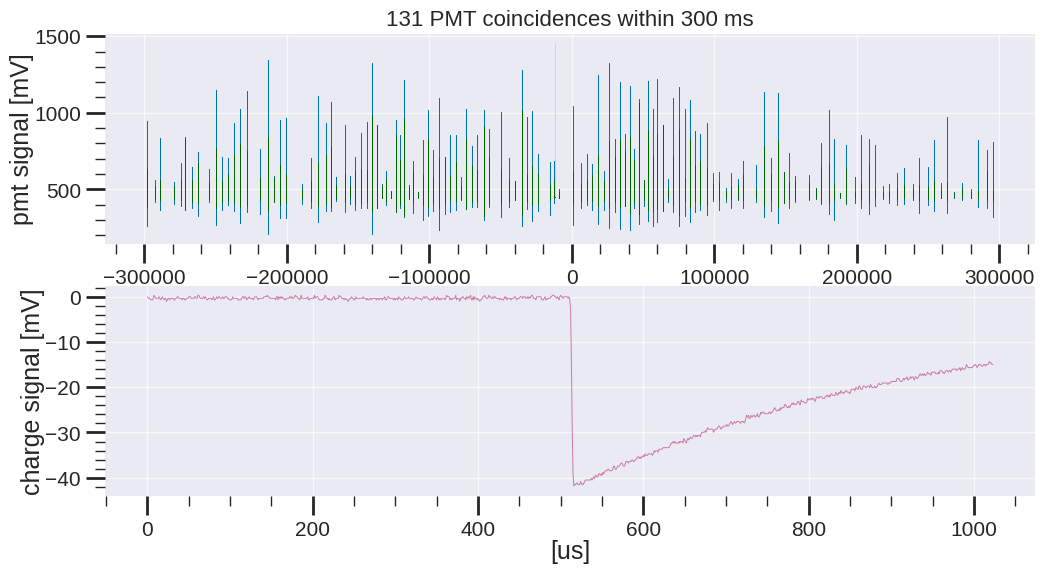

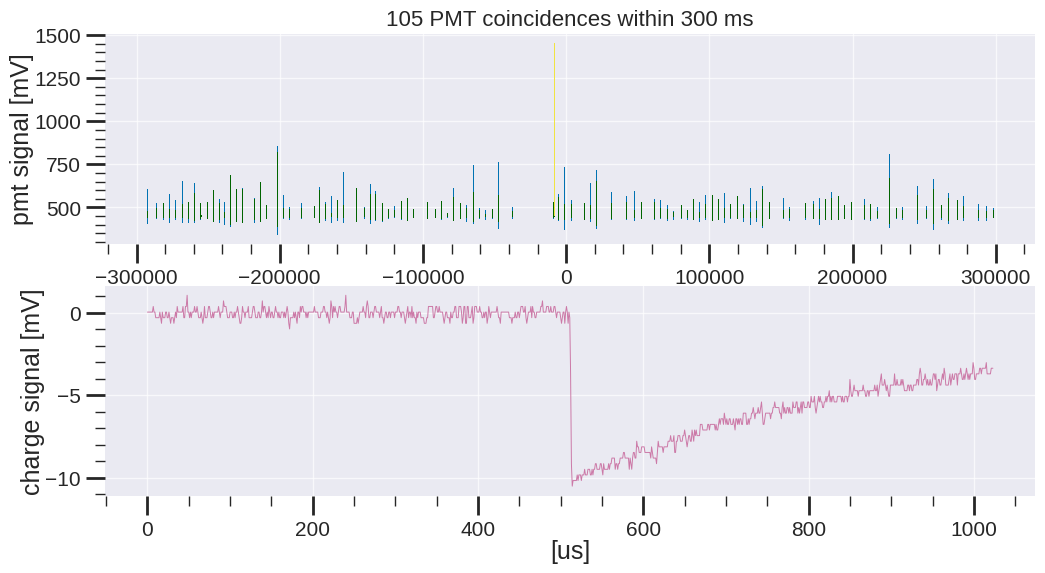

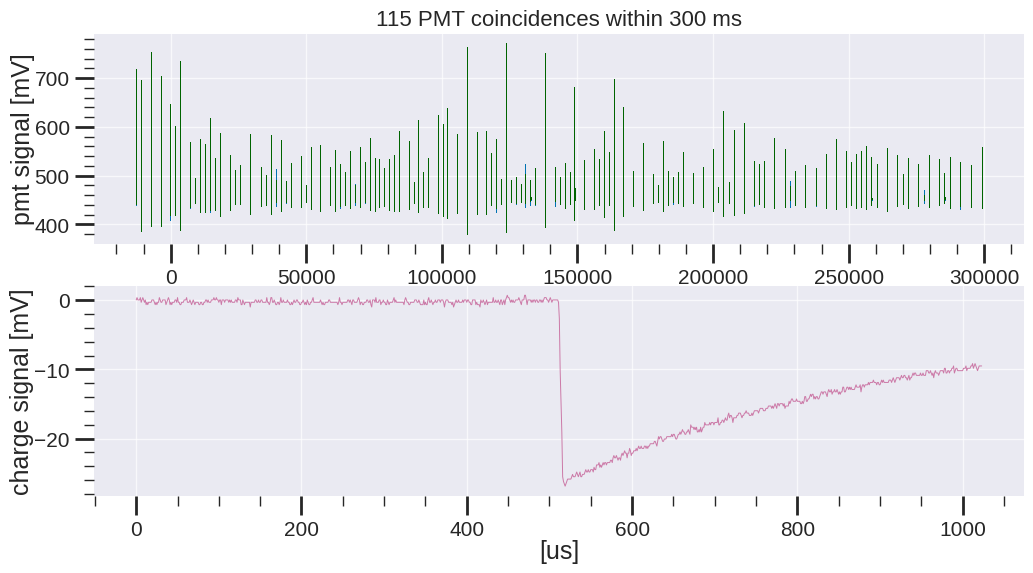

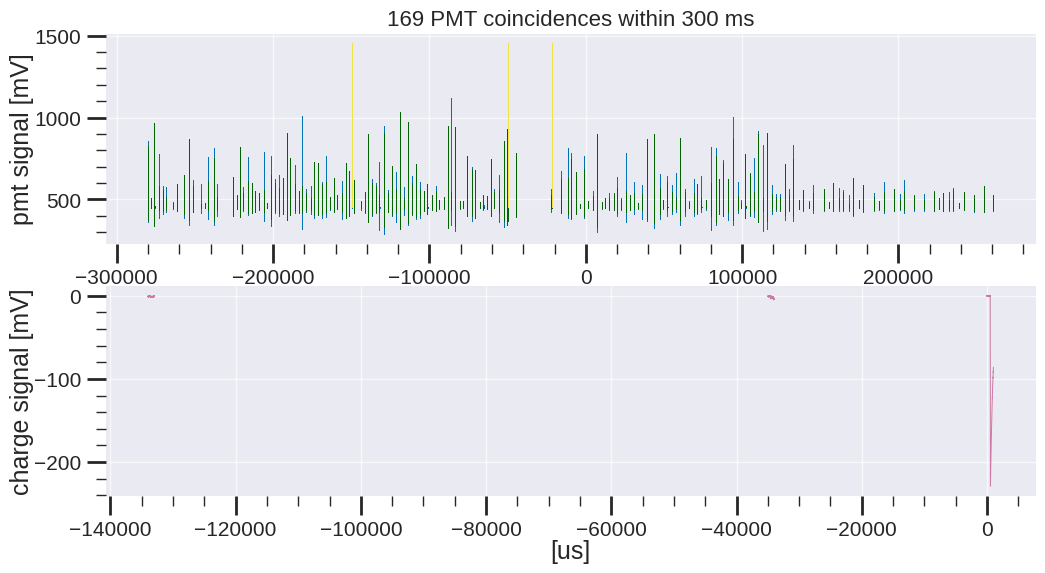

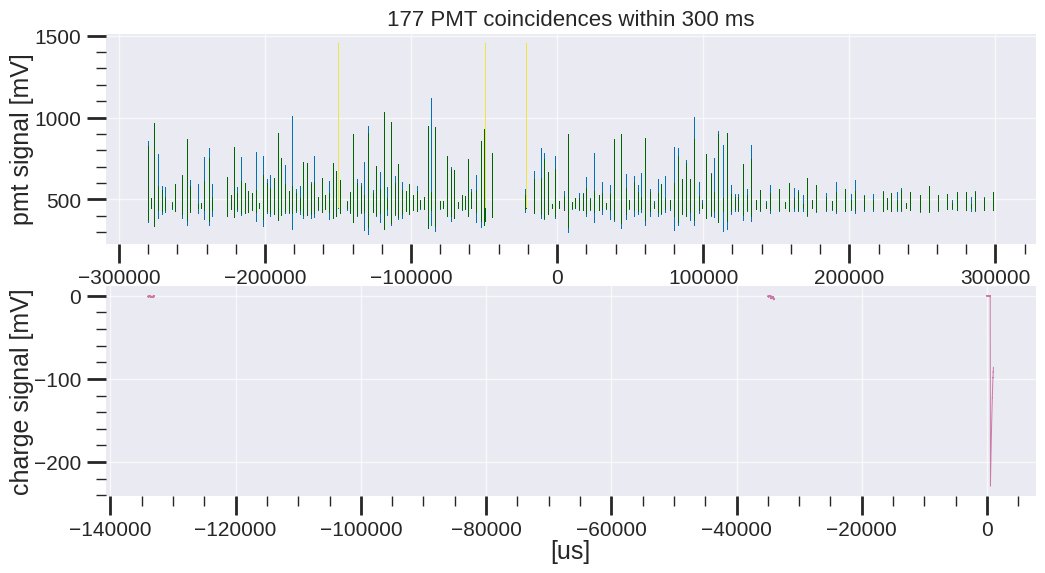

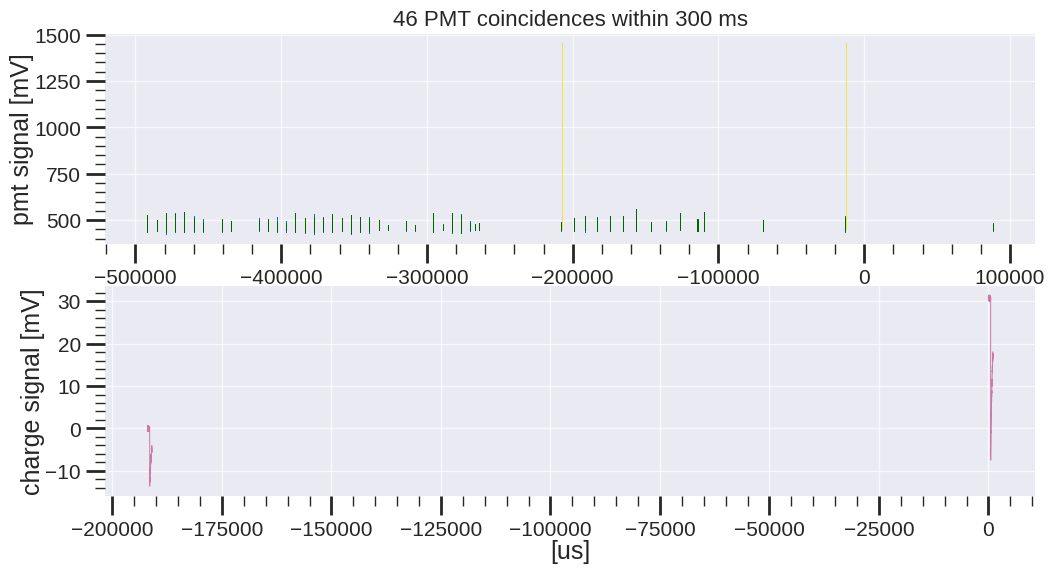

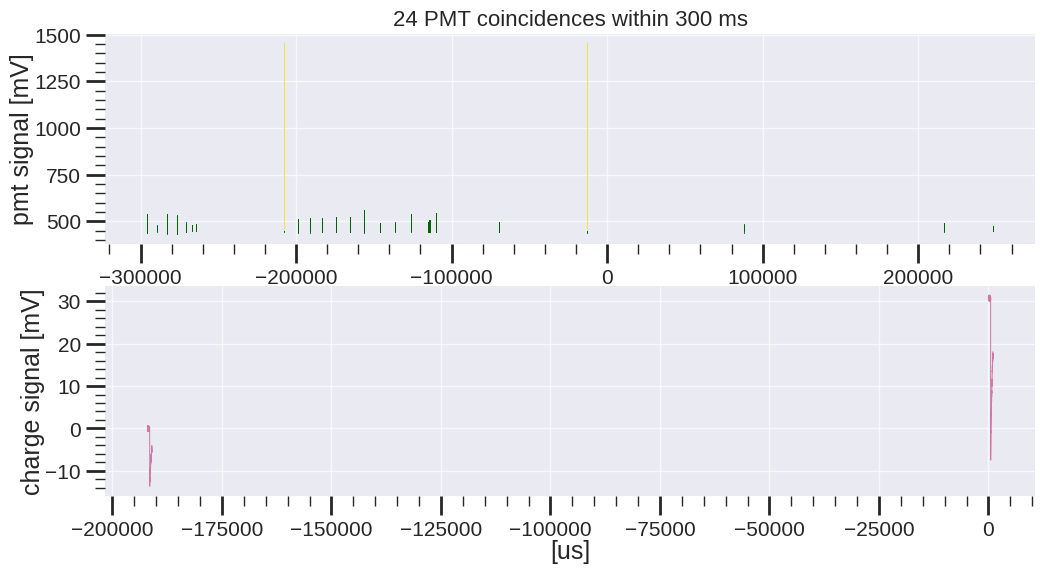

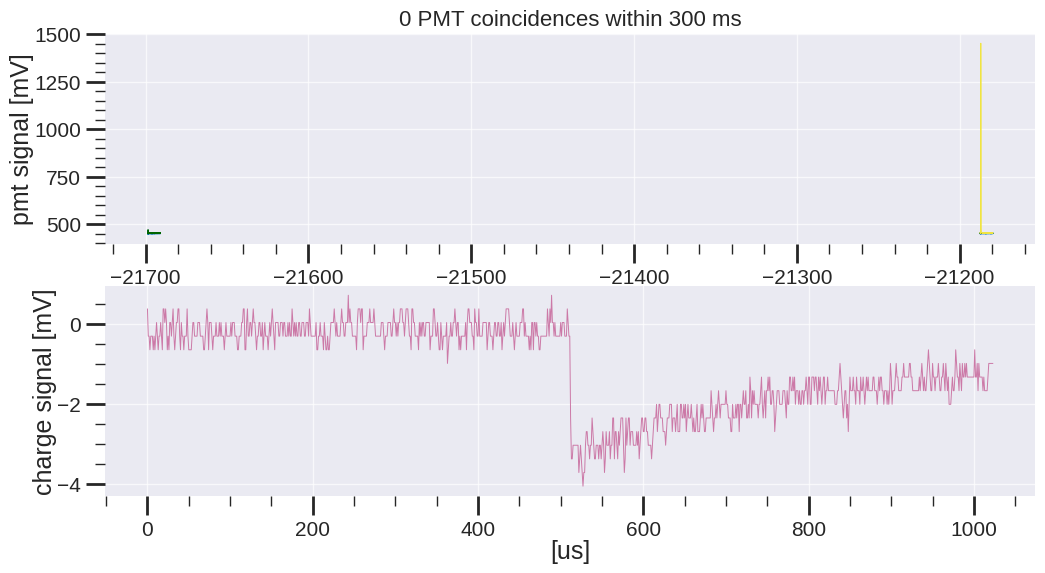

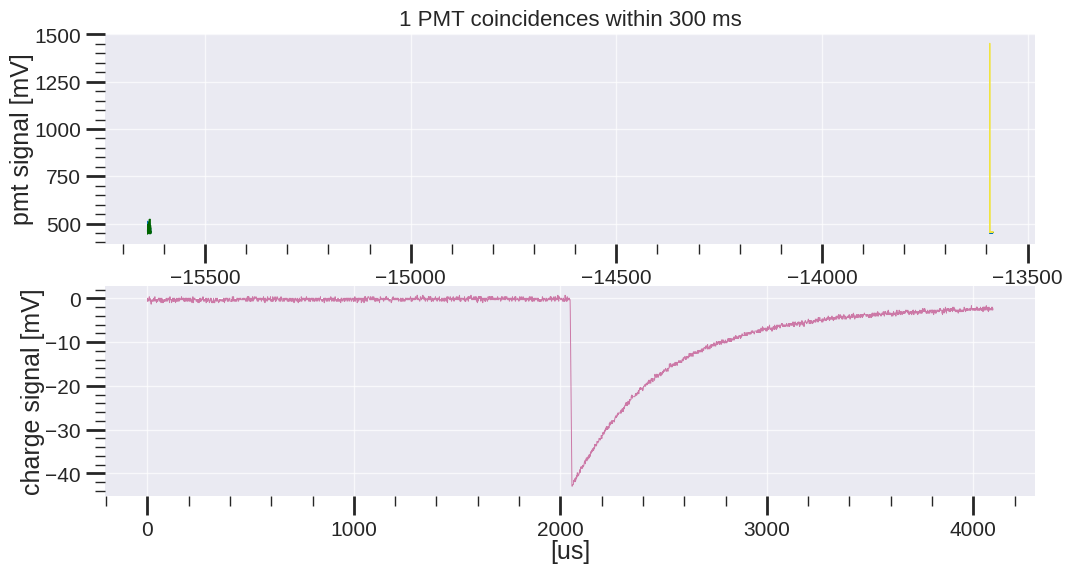

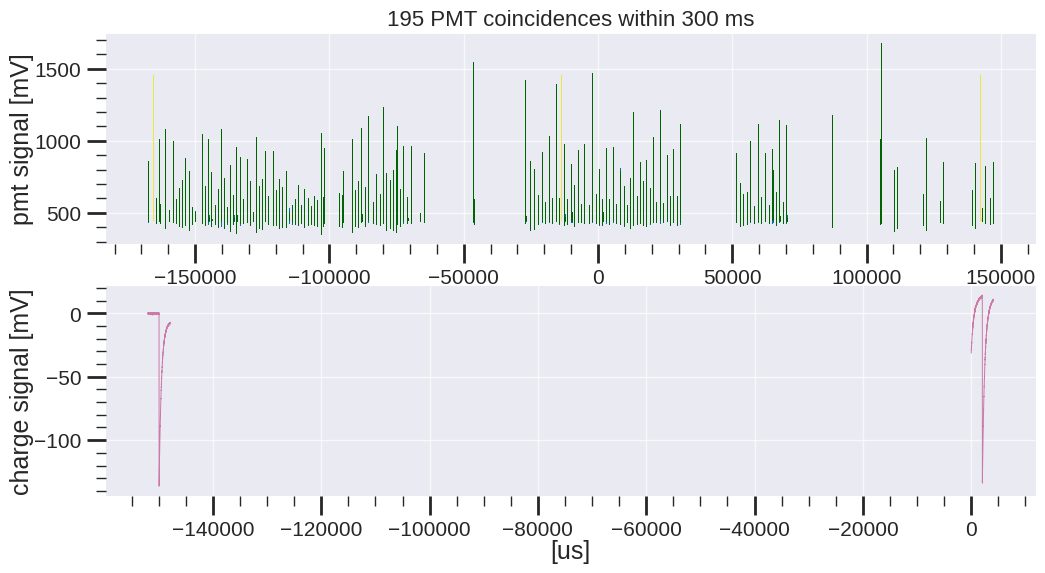

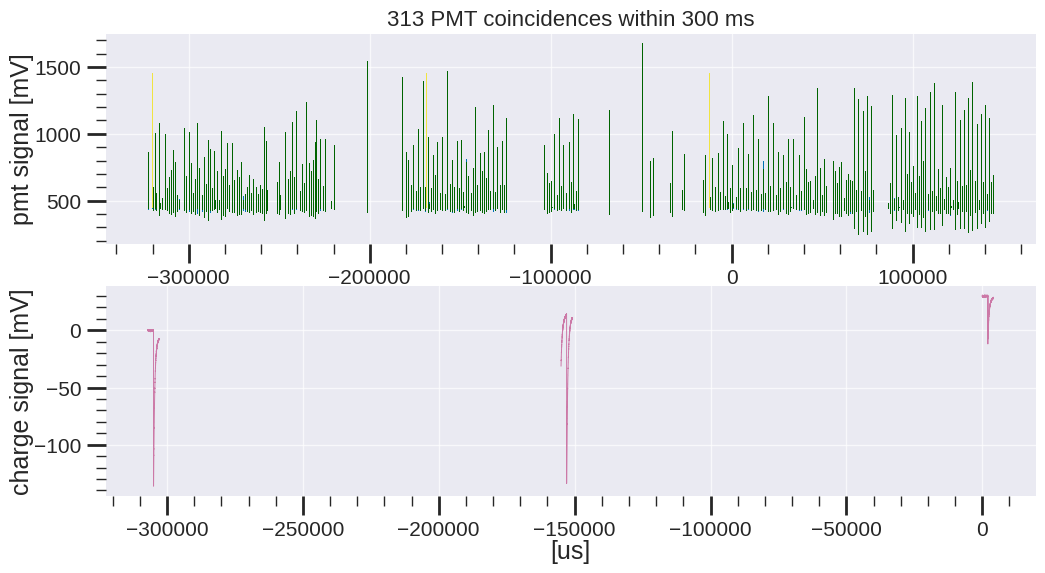

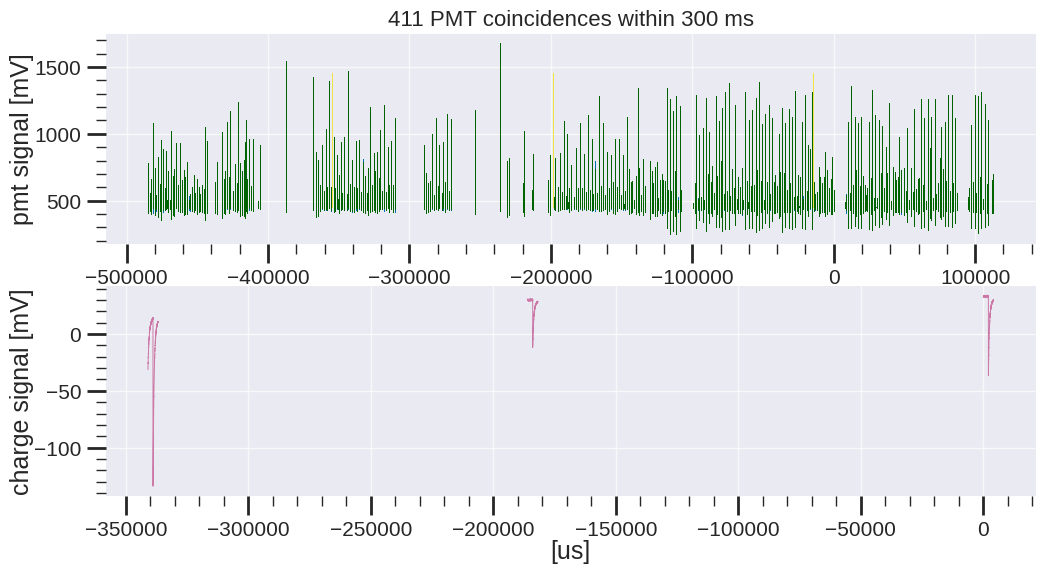

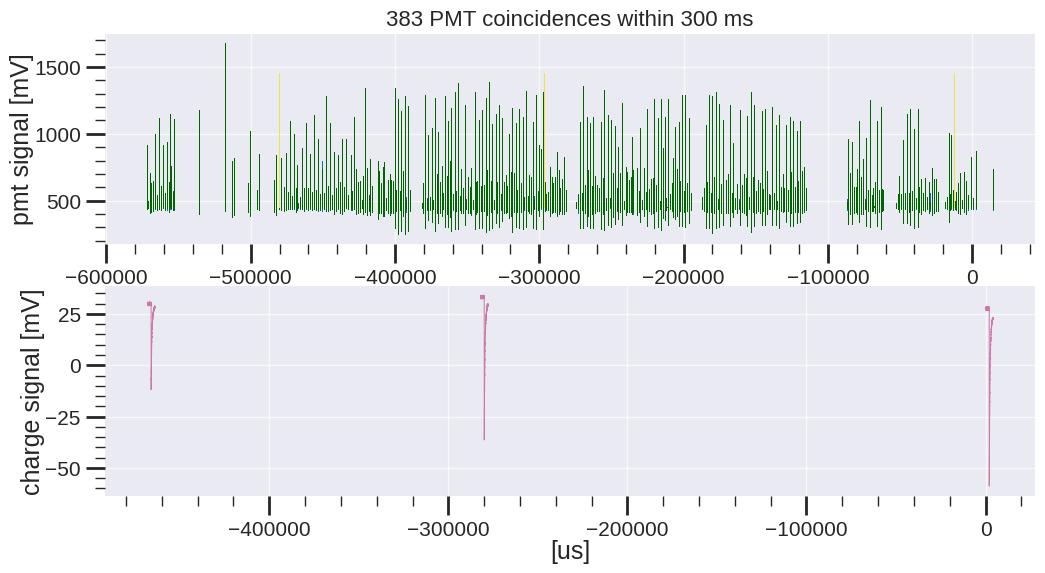

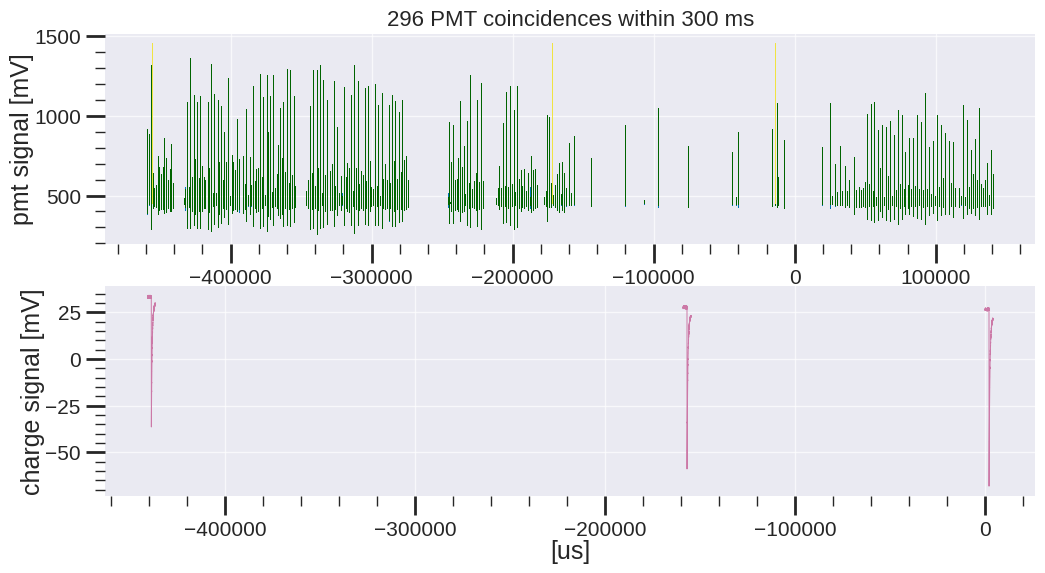

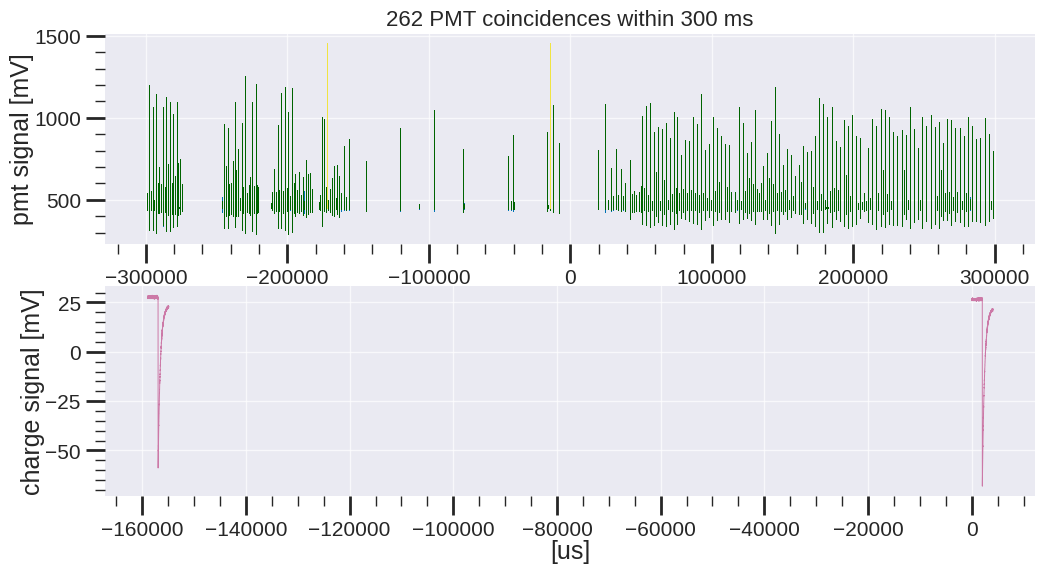

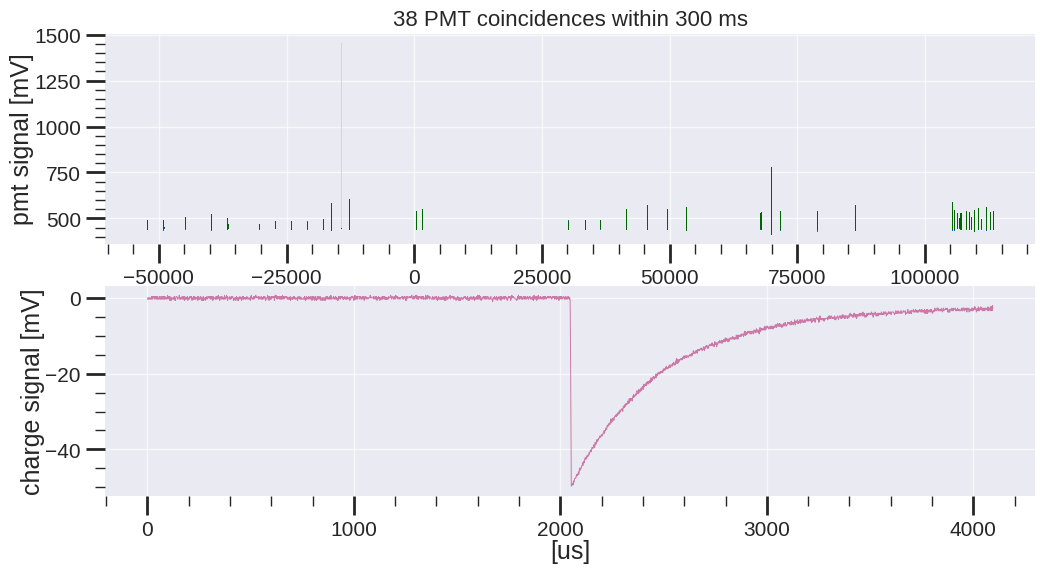

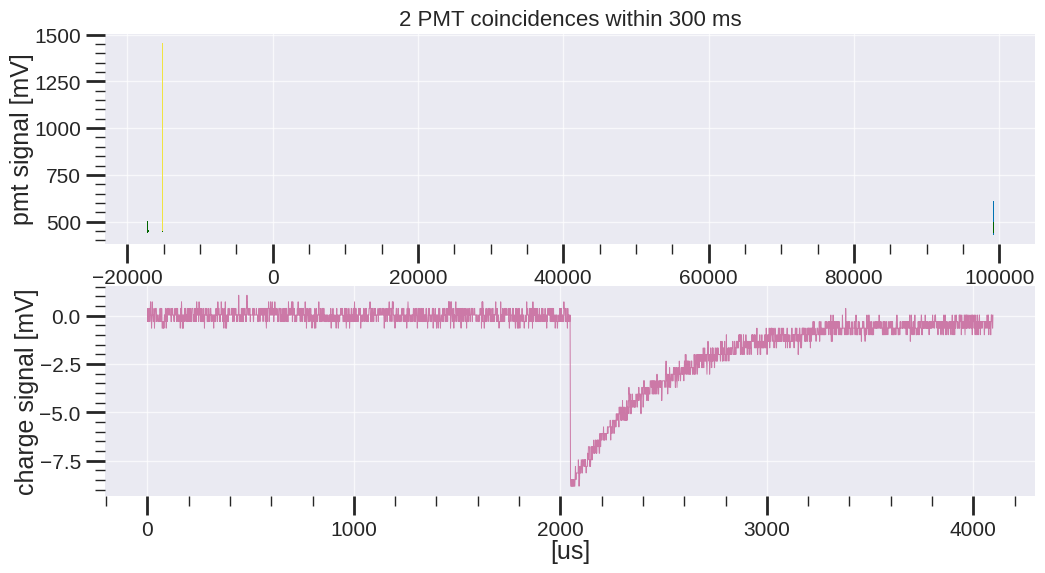

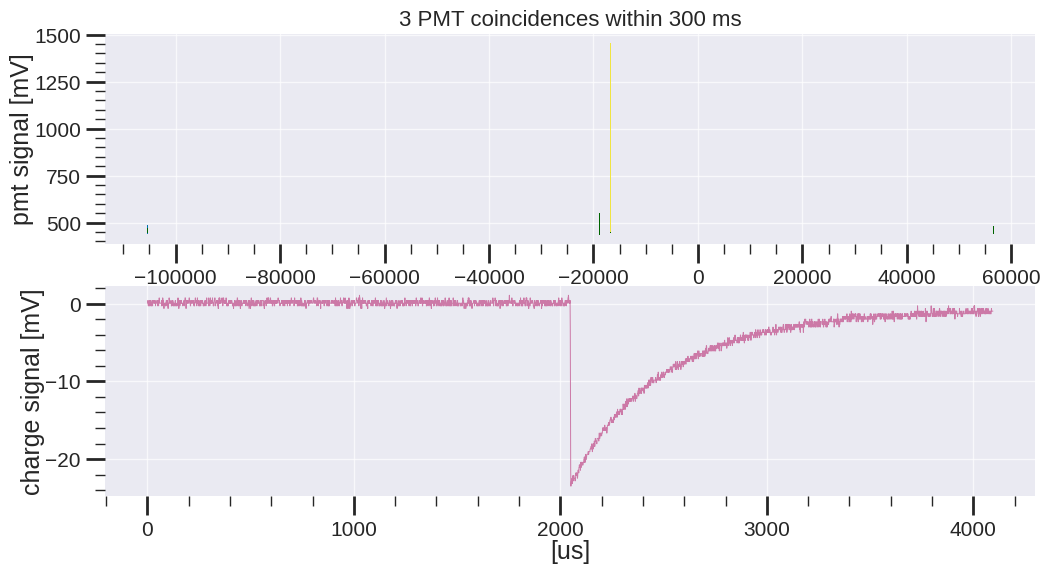

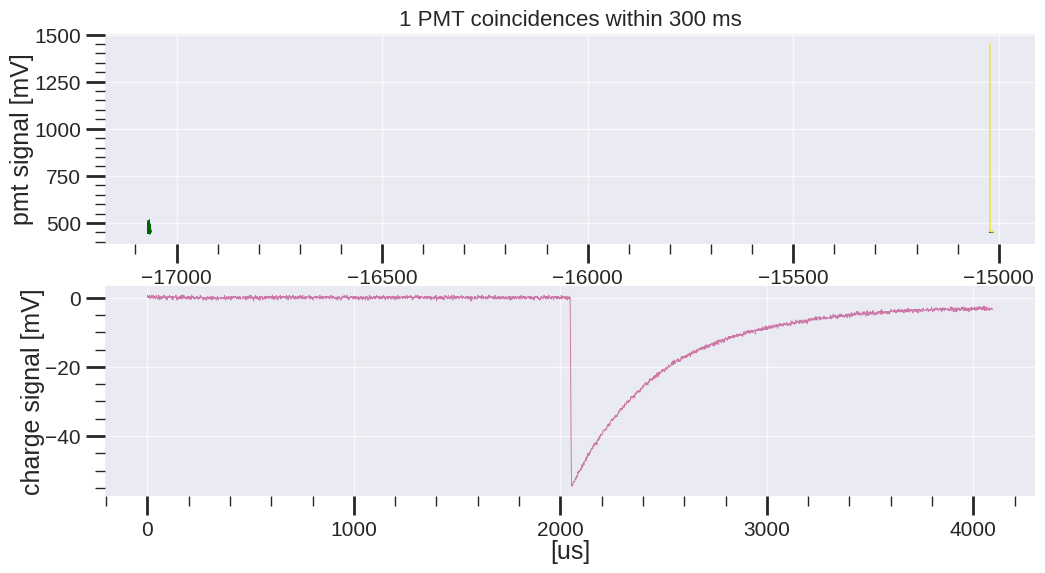

In [50]:
#This plotting mode uses two subplots, stiched together with one time axis. 
#The top subplot is the PMTs and Struck charge trigger signal. The bottom
#plot is the charge channel. 

for pltcnt, event in enumerate(wave_events):
    if(pltcnt > 20): break
    #now event is populated with a dictionary with sw channels as keys. 
    #The elements of the key event[0] is a list of events with keys "Seconds", 
    #"Nanoseconds", "Data". 
    
    #count the waves to plot. Chs 0, 1, and 4 always trigger together. However,
    #I want to plot channel 4 independently, if it has no amplitude in Ch 0 and 1. 
    N01 = 0
    N4 = 0
    N3 = len(event[3])
    pmt_thresh = 20 #mV, about the discriminator threshold
    for i, _ in enumerate(event[0]):
        if(np.max(np.abs(_["Data"] - np.mean(_["Data"][:40]))) > pmt_thresh):
            N01 += 1
        else:
            if(i < len(event[4])):
                v = event[4][i]["Data"]
                if(np.max(np.abs(v - np.mean(v[:40]))) > 100):
                    N4 += 1
    
    #first, order the events sequentially in time relative to the largest channel 3 pulse
    ch3_evs = event[3]
    absmax = 0
    ct = None #ct for center time, will be used a bit so I kept the name short
    ct_ns = None
    for _ in ch3_evs:
        if(np.max(np.abs(_["Data"])) > absmax):
            ct = _["Seconds"]
            ct_ns = _["Nanoseconds"]
    
    #add a zero'd time key to each waveform element
    mod_event = {}
    for ch in event:
        mod_event[ch] = []
        for w in event[ch]:
            mod_event[ch].append(w)
            mod_event[ch][-1]['zt'] = w["Seconds"] - ct + (w["Nanoseconds"] - ct_ns)/1e9
        
        #sort by this
        mod_event[ch] = sorted(mod_event[ch], key=lambda k: k['zt'])
    
    
    #create the two subplots
    fig, (axt, axb) = plt.subplots(figsize=(12, 6), nrows=2)
    for ch in [0, 1, 4]:
        for wi, w in enumerate(mod_event[ch]):
            wf = w["Data"]
            if(np.max(np.abs(wf - np.mean(wf[:40]))) < 100 and ch == 4): continue
            times = np.arange(0, len(wf)*dT[ch], dT[ch])
            times = times + w['zt']*1e6
            axt.plot(times, wf, color=colors[ch], linewidth=0.7)

    for ch in [3]:
        for w in mod_event[ch]:
            wf = w["Data"]
            times = np.arange(0, len(wf)*dT[ch], dT[ch])
            times = times + w['zt']*1e6
            axb.plot(times, wf, color=colors[ch], linewidth=0.7)
    
    axt.set_title("{:d} PMT coincidences within 300 ms".format(N01))
    axt.set_ylabel("pmt signal [mV]")
    axb.set_ylabel("charge signal [mV]")
    axt.set_xlabel("[us]")
    axb.set_xlabel("[us]")
    
    plt.show()
    


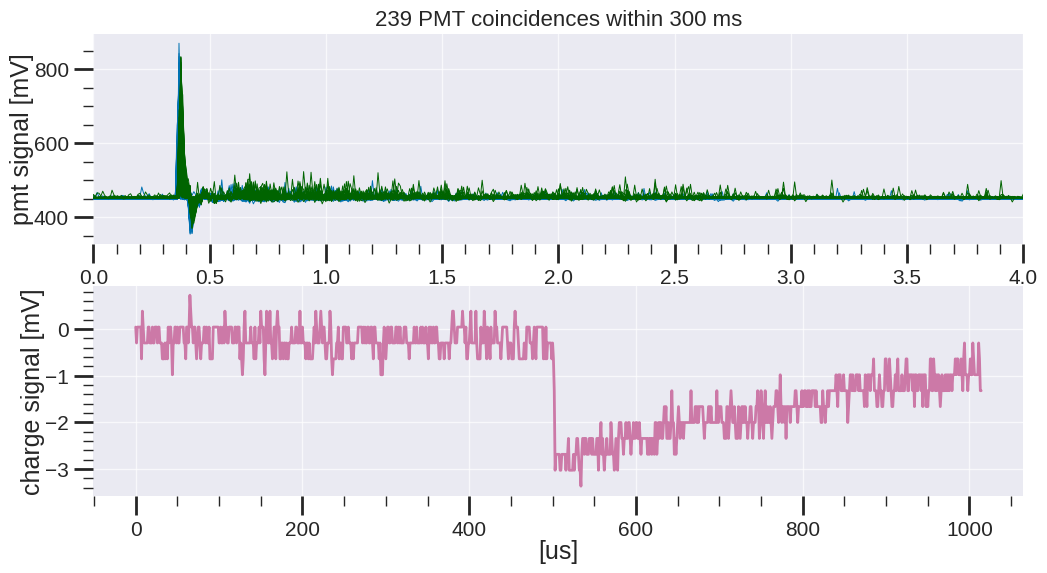

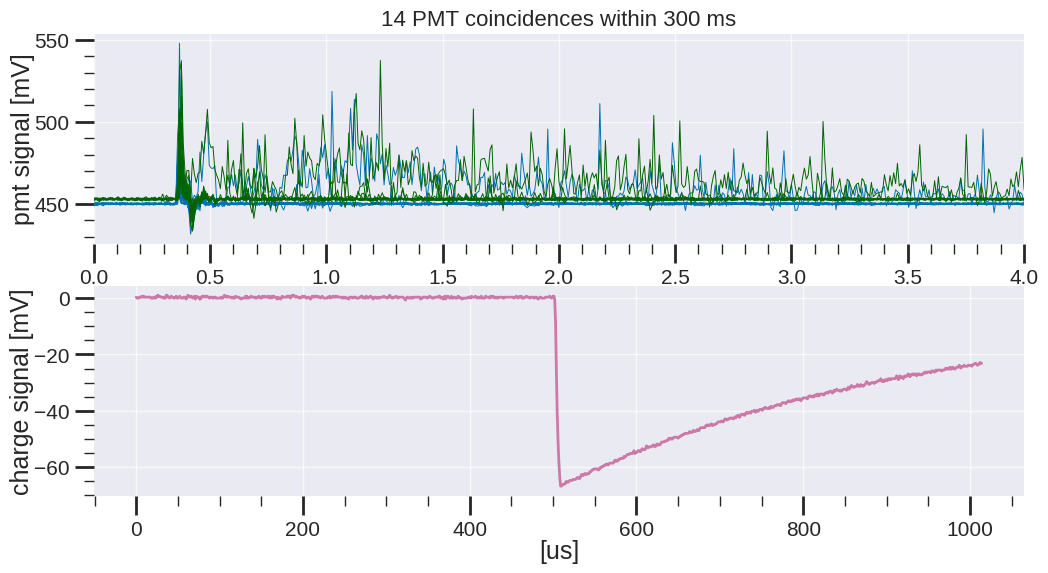

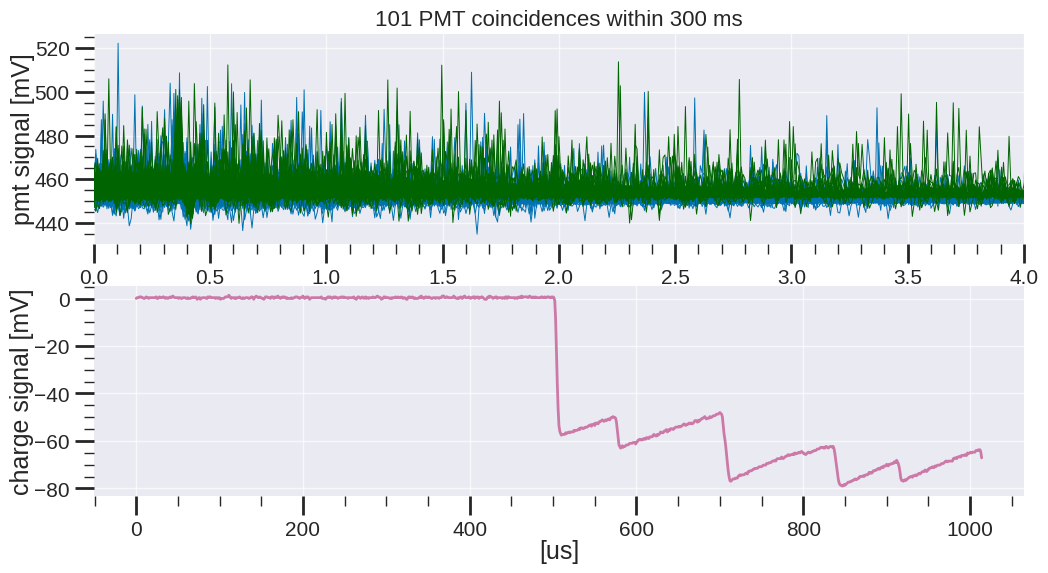

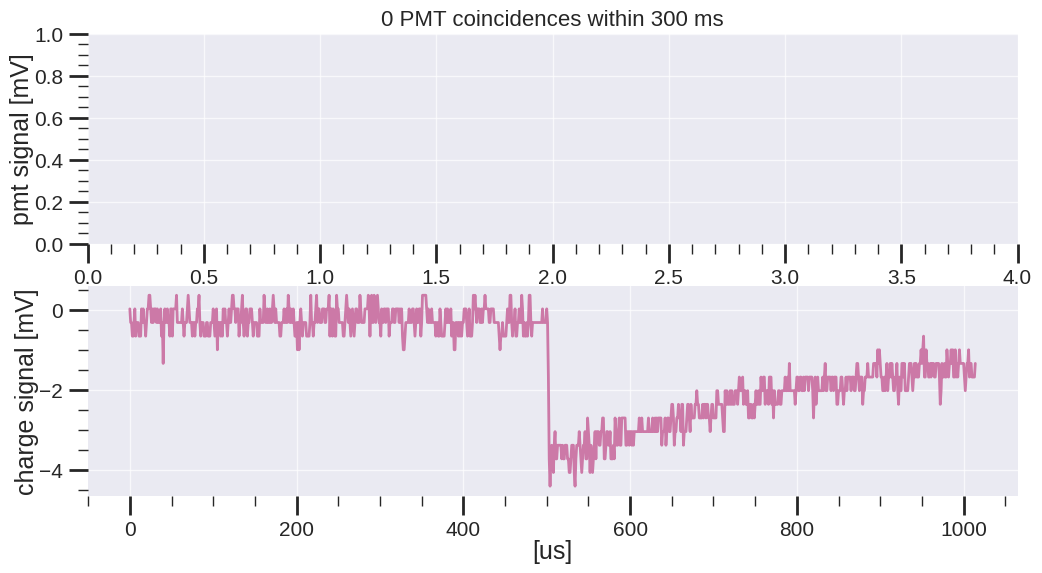

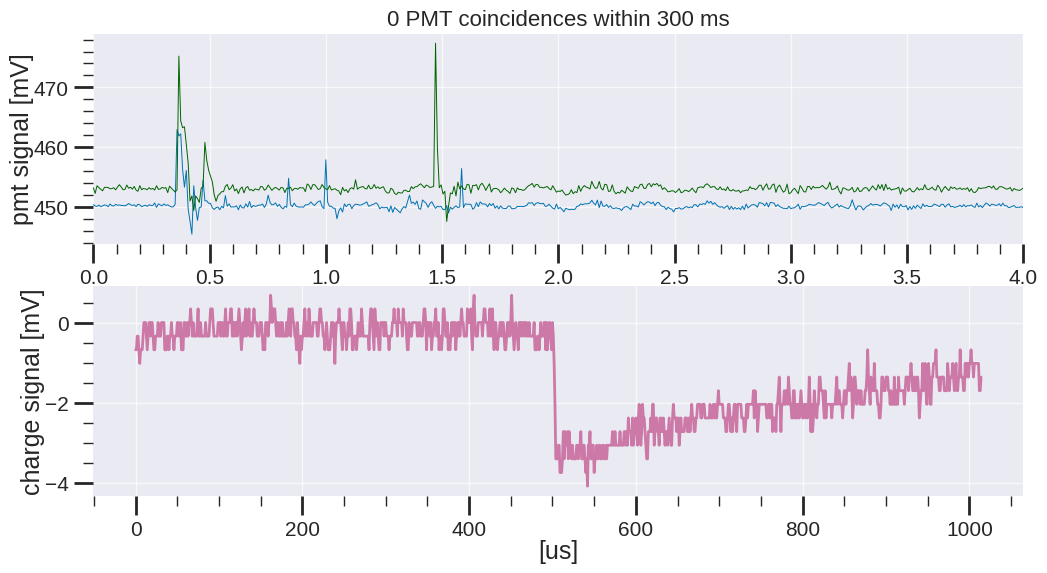

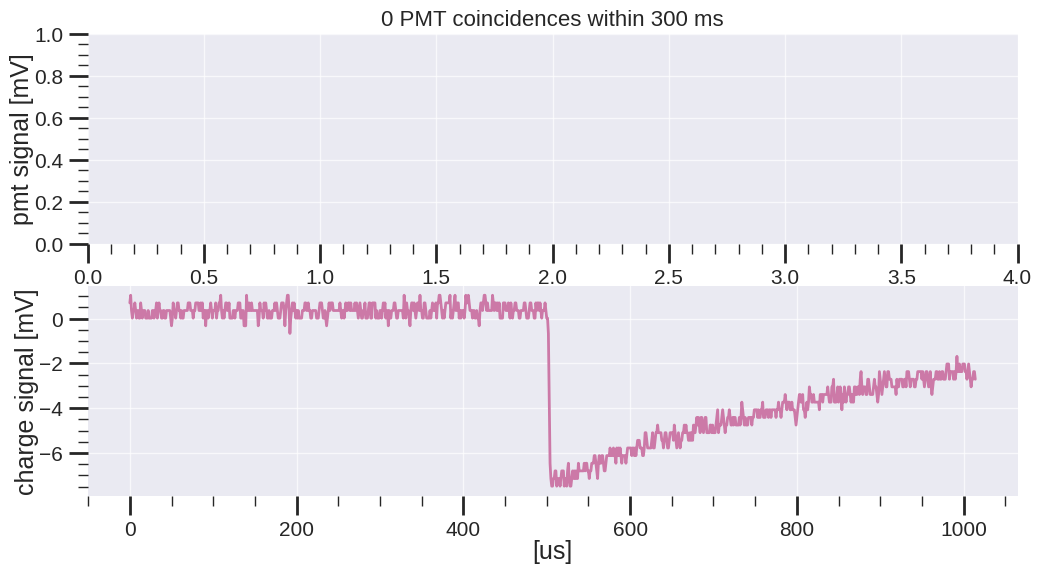

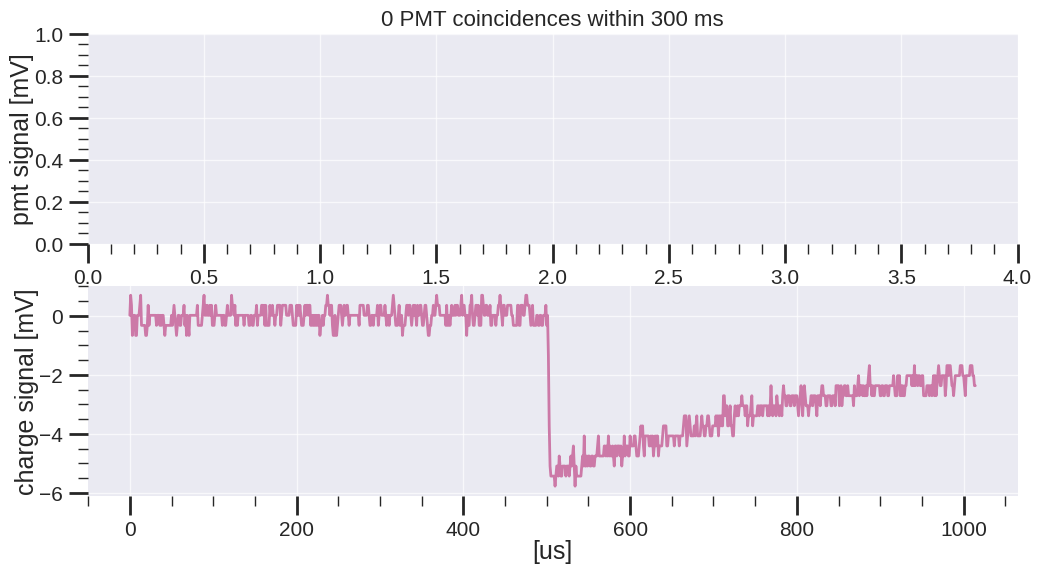

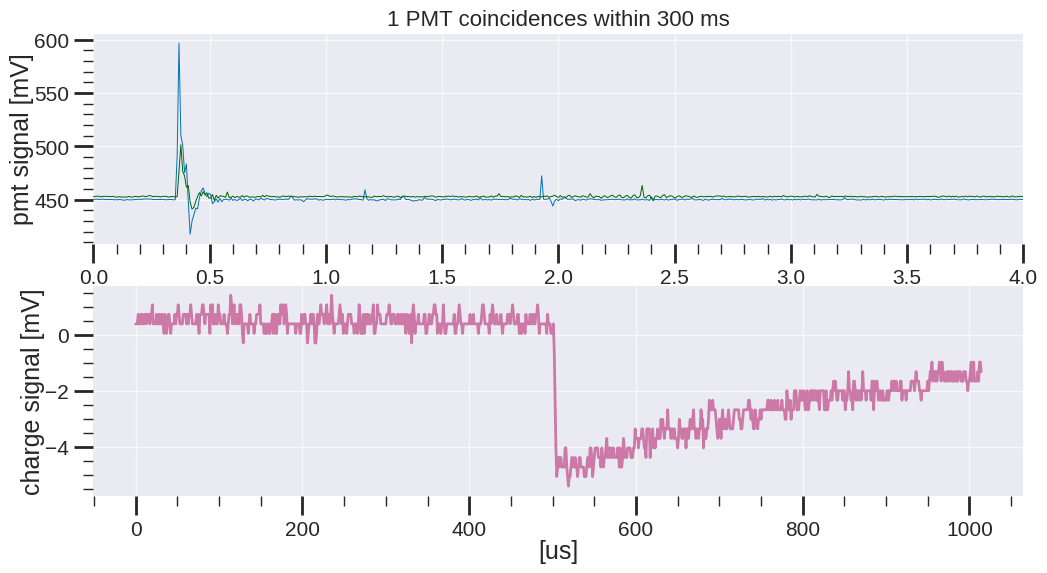

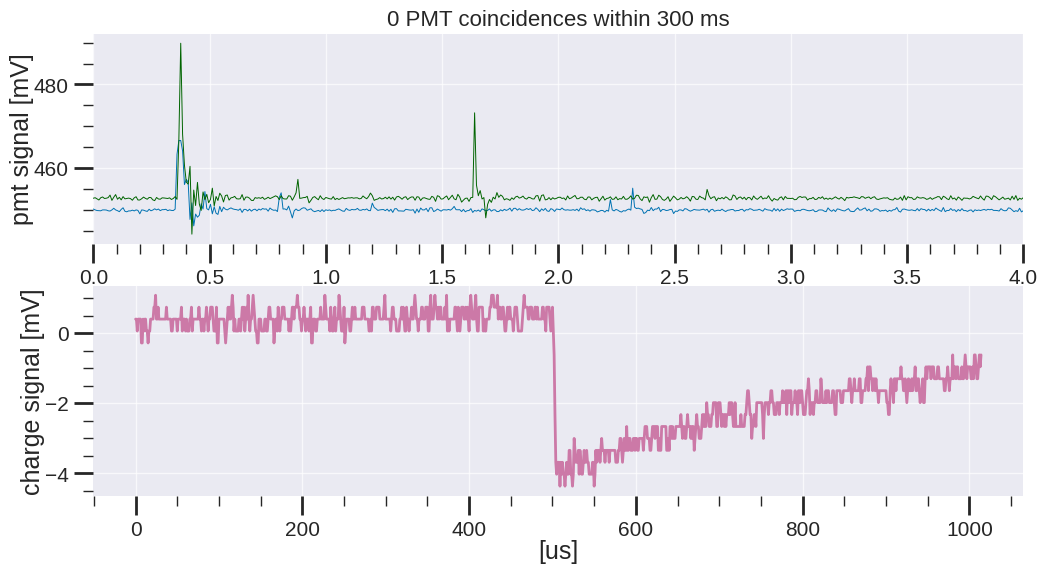

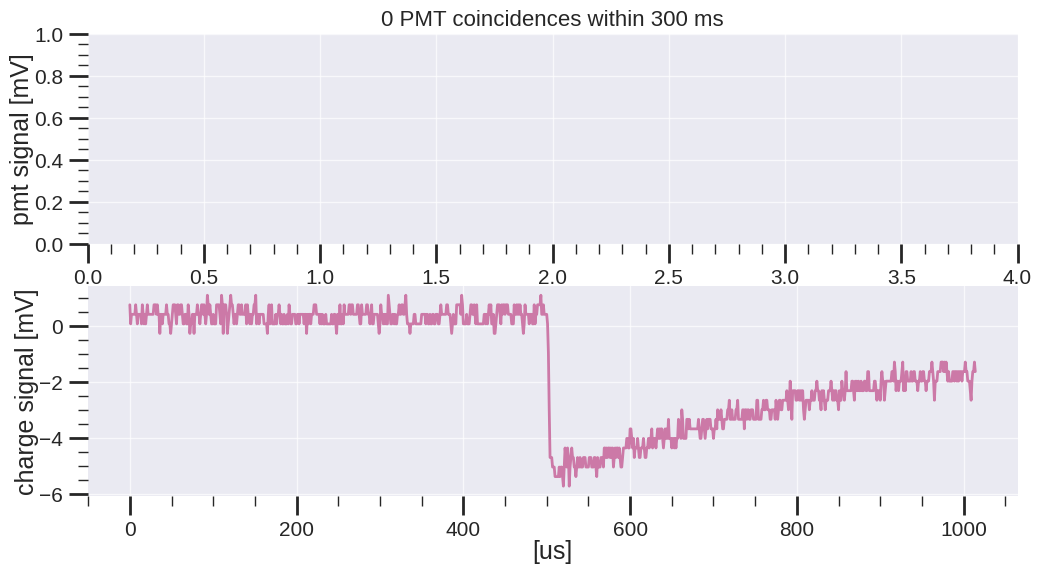

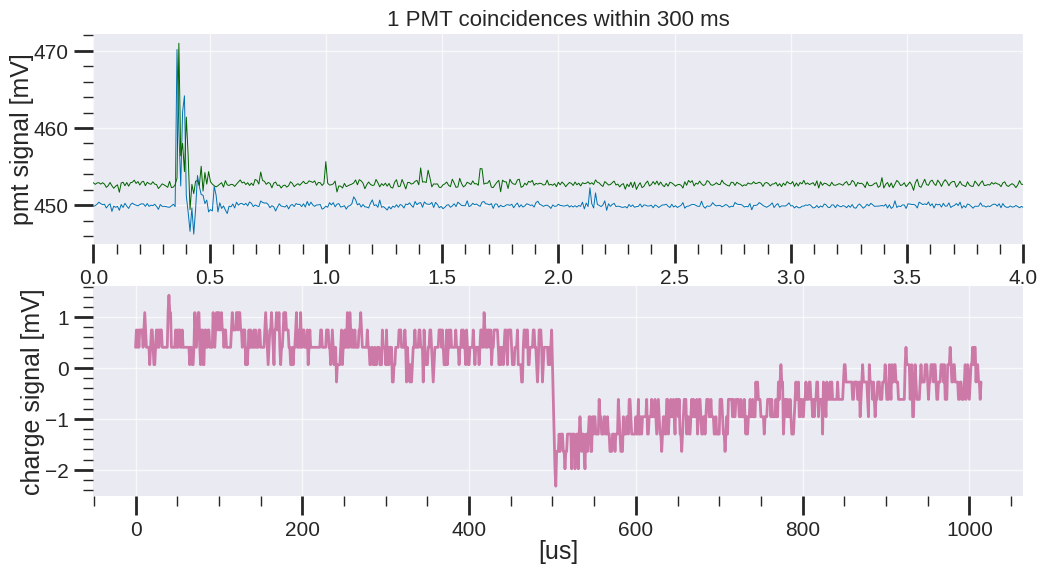

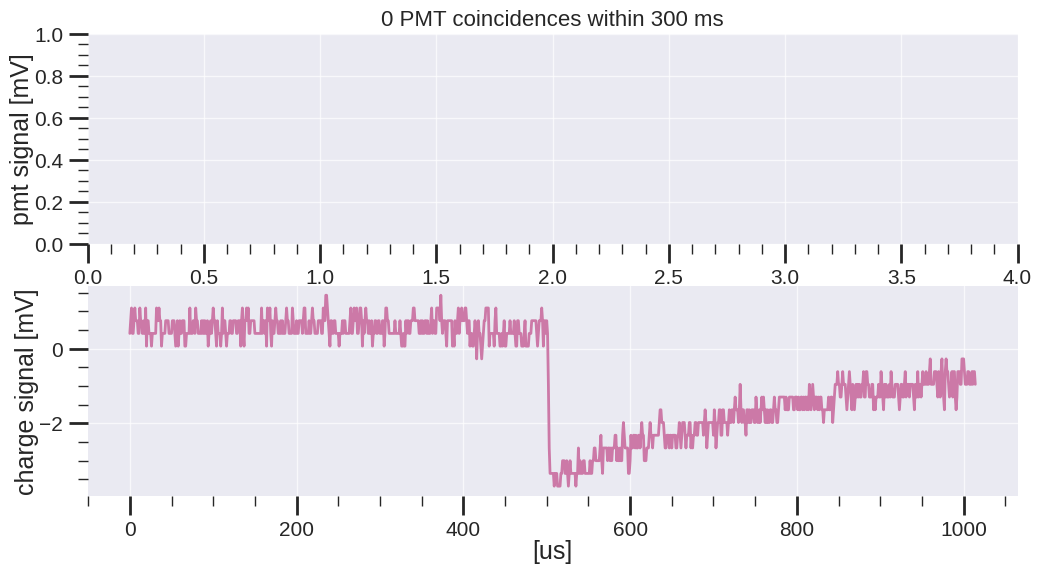

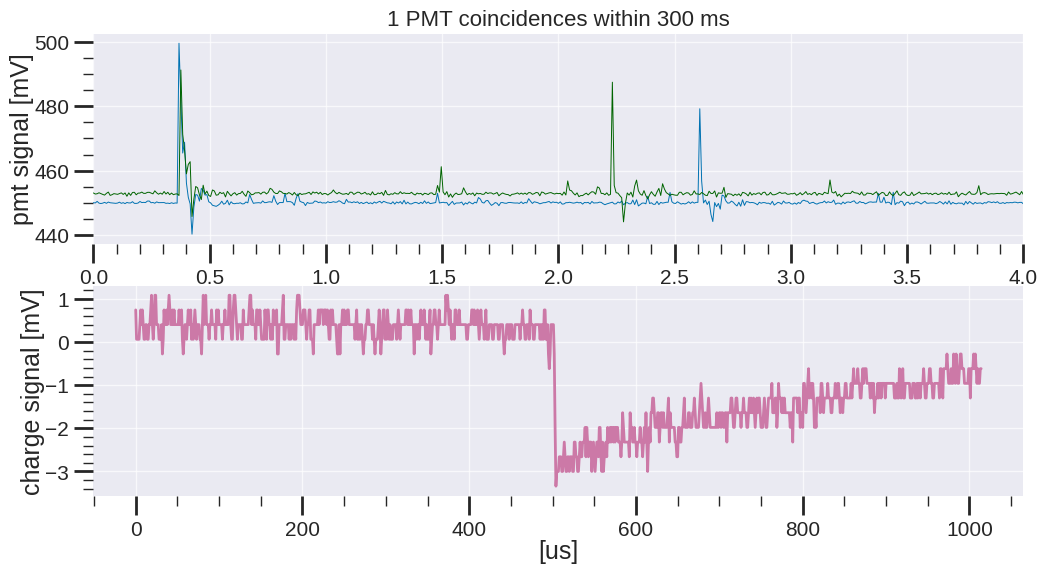

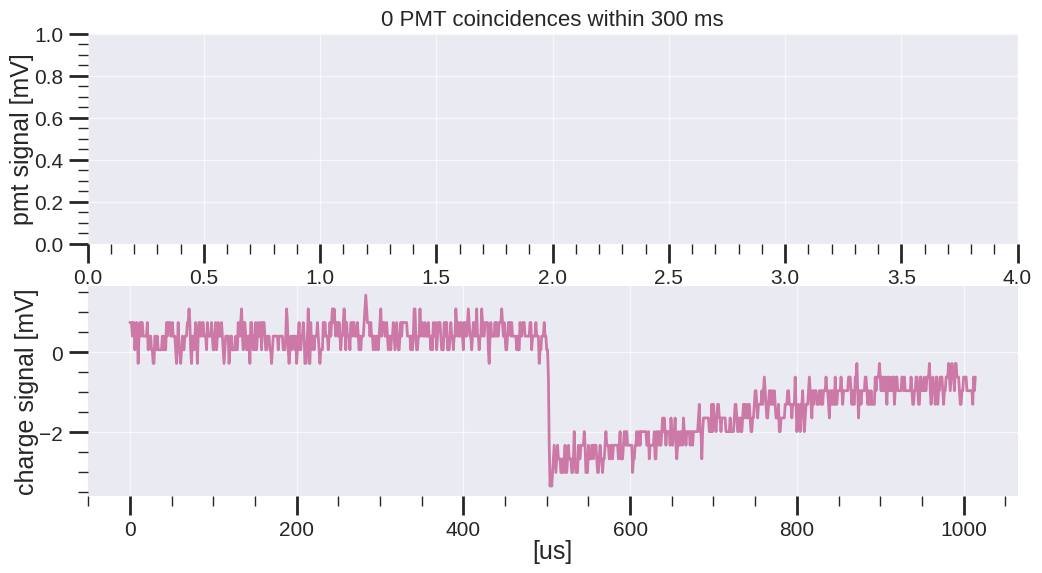

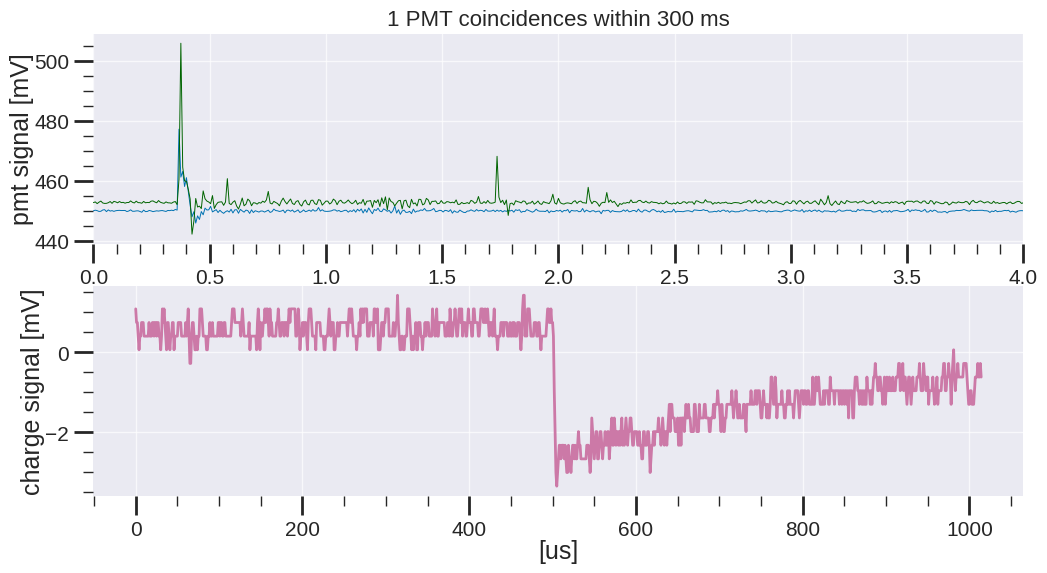

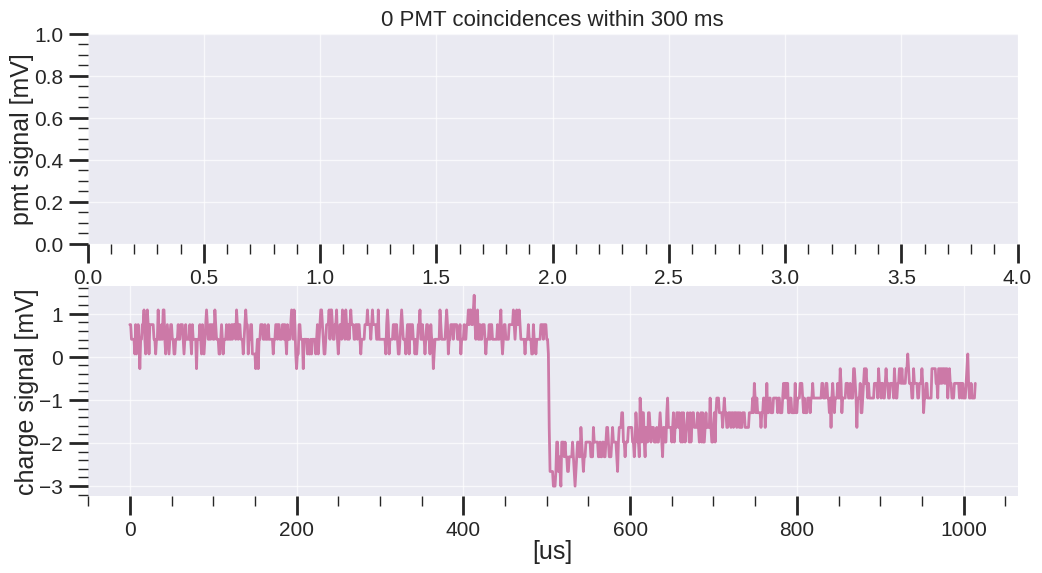

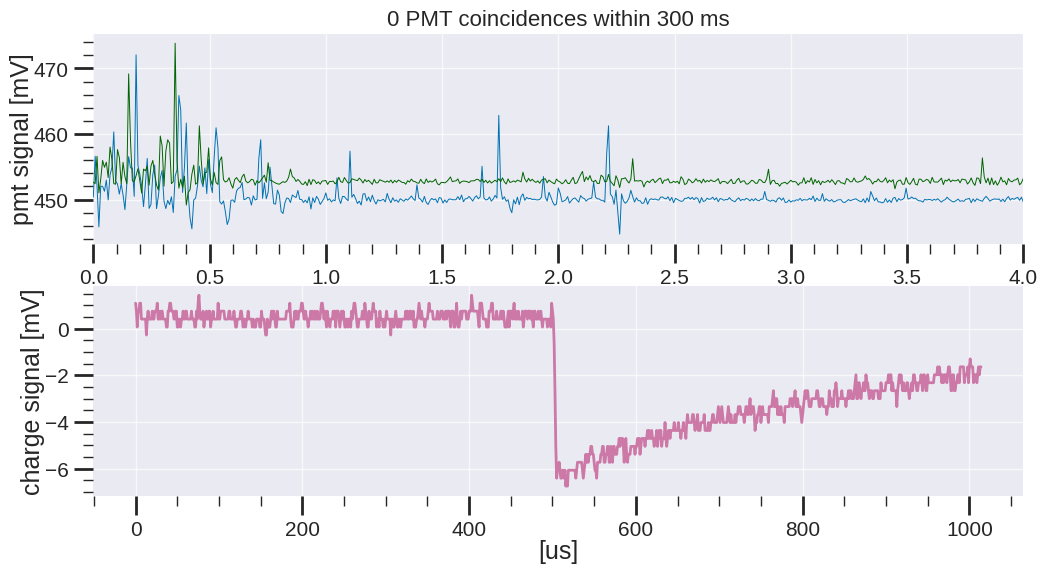

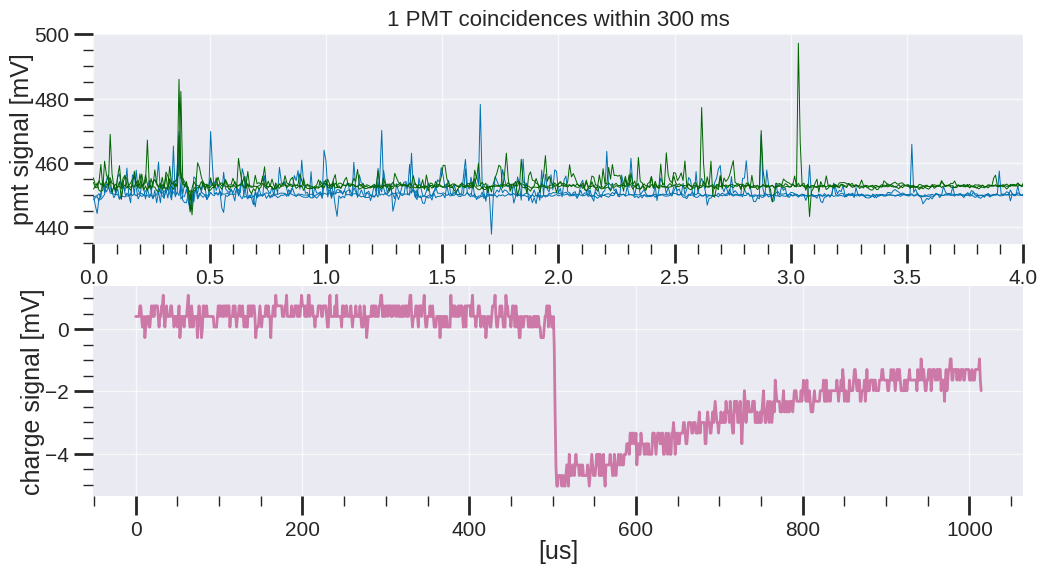

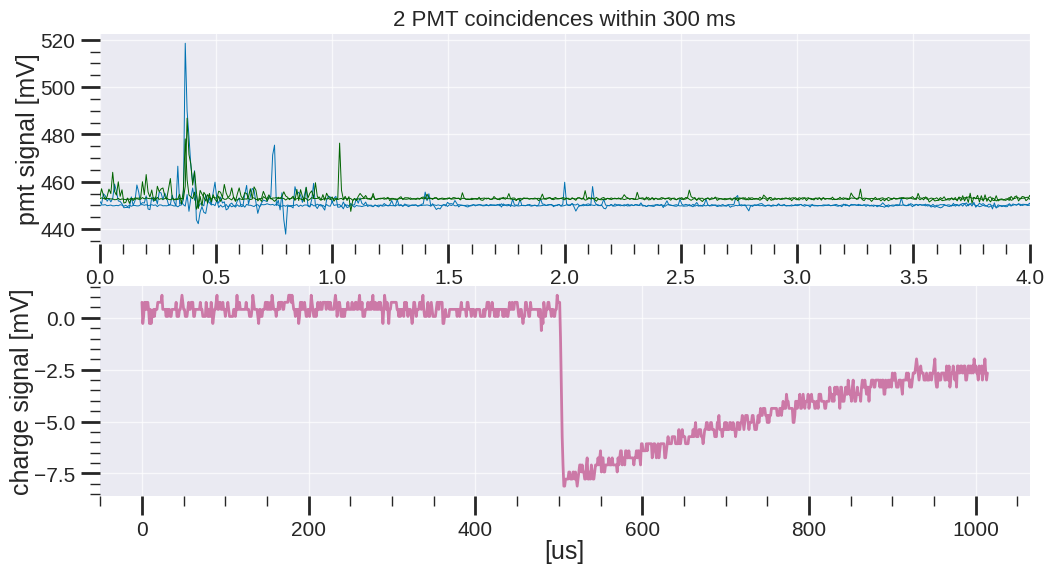

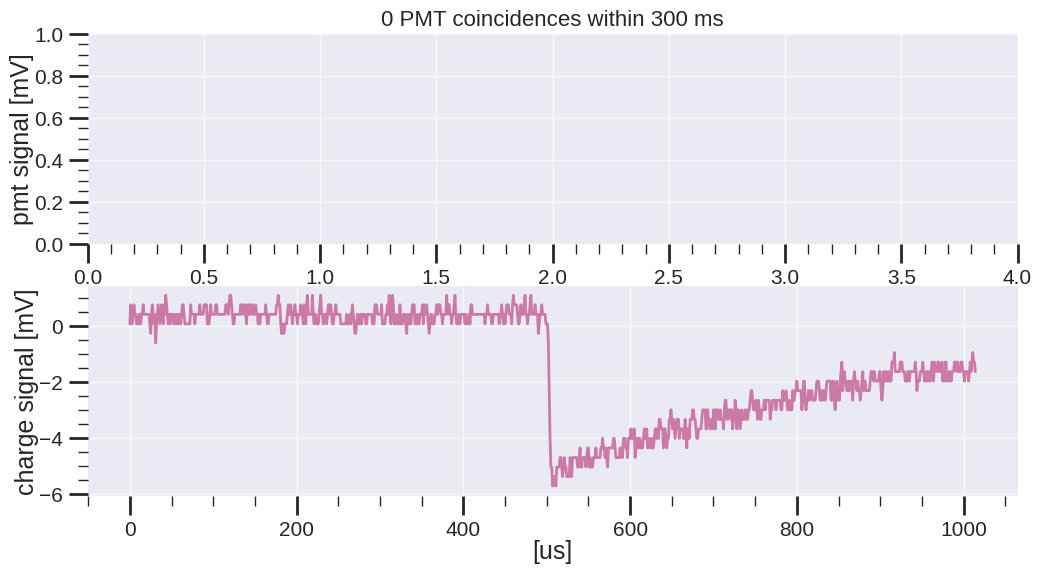

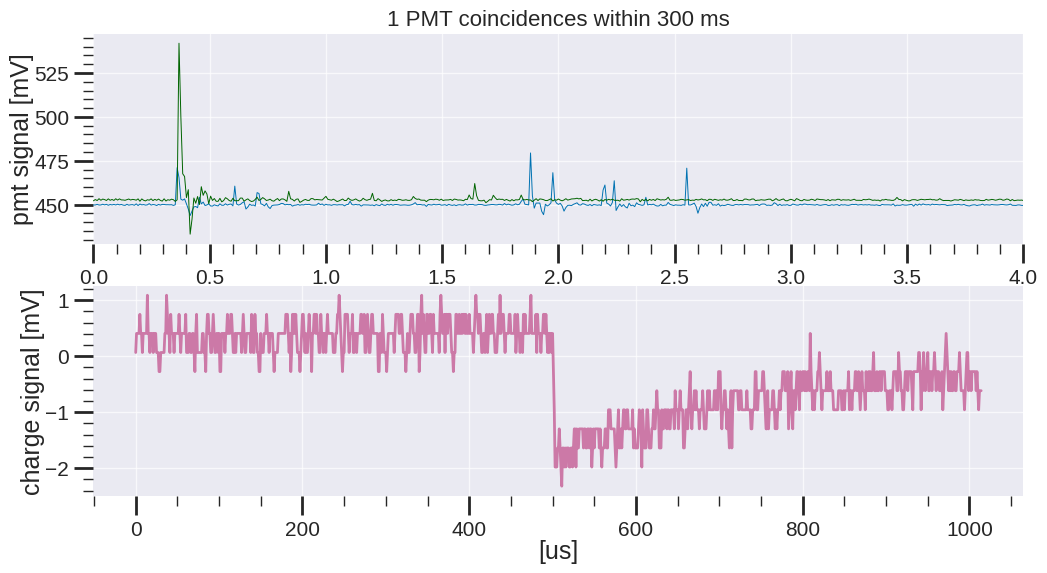

In [59]:
#This plotting mode overlays all of the waveforms on top of eachother


for pltcnt, event in enumerate(wave_events):
    if(pltcnt > 20): break
    #now event is populated with a dictionary with sw channels as keys. 
    #The elements of the key event[0] is a list of events with keys "Seconds", 
    #"Nanoseconds", "Data". 
    
    #count the waves to plot. Chs 0, 1, and 4 always trigger together. However,
    #I want to plot channel 4 independently, if it has no amplitude in Ch 0 and 1. 
    N01 = 0
    N4 = 0
    N3 = len(event[3])
    pmt_thresh = 20 #mV, about the discriminator threshold
    for i, _ in enumerate(event[0]):
        if(np.max(np.abs(_["Data"] - np.mean(_["Data"][:40]))) > pmt_thresh):
            N01 += 1
        #else:
        #    if(i < len(event[4])):
        #        v = event[4][i]["Data"]
        #        if(np.max(np.abs(v - np.mean(v[:40]))) > 100):
        #            N4 += 1
    
    #first, order the events sequentially in time relative to the largest channel 3 pulse
    ch3_evs = event[3]
    absmax = 0
    ct = None #ct for center time, will be used a bit so I kept the name short
    ct_ns = None
    for _ in ch3_evs:
        if(np.max(np.abs(_["Data"])) > absmax):
            ct = _["Seconds"]
            ct_ns = _["Nanoseconds"]
    
    #add a zero'd time key to each waveform element
    mod_event = {}
    for ch in event:
        mod_event[ch] = []
        for w in event[ch]:
            mod_event[ch].append(w)
            mod_event[ch][-1]['zt'] = w["Seconds"] - ct + (w["Nanoseconds"] - ct_ns)/1e9
        
        #sort by this
        mod_event[ch] = sorted(mod_event[ch], key=lambda k: k['zt'])
    
    
    #create the two subplots
    fig, (axt, axb) = plt.subplots(figsize=(12, 6), nrows=2)
    for ch in [0, 1]:
        for wi, w in enumerate(mod_event[ch]):
            wf = w["Data"]
            if(np.max(np.abs(wf - np.mean(wf[:40]))) < 100 and ch == 4): continue
            times = np.arange(0, len(wf)*dT[ch], dT[ch])
            axt.plot(times, wf, color=colors[ch], linewidth=0.7)

    for ch in [3]:
        for w in mod_event[ch]:
            wf = w["Data"]
            times = np.arange(0, len(wf)*dT[ch], dT[ch])
            axb.plot(times, wf, color=colors[ch], linewidth=2)
    
    axt.set_title("{:d} PMT coincidences within 300 ms".format(N01))
    axt.set_ylabel("pmt signal [mV]")
    axb.set_ylabel("charge signal [mV]")
    axt.set_xlabel("[us]")
    axb.set_xlabel("[us]")
    #axb.set_xlim([400, 1000])
    axt.set_xlim([0, 4])
    plt.show()
    


# Find events that are well separated from any charge events, and overlay

In [25]:
# get times of charge depositing pulses
#get any charge events above 2 mV
amp_th = 2
events = [] #{"time": datetime, "amp": mV, "hv": kV con}
for f in ds.ad2_files:
    df, date = pickle.load(open(f, "rb")) #opens the pandas dataframe object in the pickle file
    for evidx, row in df.iterrows():
        ch1 = row["Data"][0]
        dT = row["dT"]
        if(np.max(ch1) > amp_th):
            amp = np.max(ch1)
            kv = ds.get_hv_at_time(row["Seconds"])
            events.append({"time":row["Seconds"], "amp":amp, "hv":kv})

ch_events = events

In [38]:
plt.ioff()
nevts_per_plot = 10
nplots = 100
proximity = 60 #seconds, minimum distance to any charge deposition phenomena
ds.reload_struck_timebounds()
for i in range(nplots):
    f = np.random.choice(ds.struck_files)
    df, date = pickle.load(open(f, "rb"))
    evs = df.sample(nevts_per_plot, replace=False)
    fig, ax = plt.subplots()
    
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.6, 0.5, 0.2, 0.2]
    ax_in = fig.add_axes([left, bottom, width, height])

    ev_counter = 0
    for _, ev in evs.iterrows():
        #check to make sure that this event is not in proximity
        #to charge deposition event
        t0 = ev["Seconds"]
        dont_plot = False
        for ch_ev in ch_events:
            if(np.abs(ch_ev["time"] - t0) < proximity):
                dont_plot = True
        if(dont_plot == False):
            ds.plot_light(ev, ax=ax, ax_in=ax_in)
            ev_counter += 1
    ax_in.set_xlim([0.3, 0.6])
    ax_in.patch.set_edgecolor('black')  
    ax_in.patch.set_linewidth(1) 
    ax.set_title("{:d} PMT events (two channels) not in proximity to charge depositions".format(ev_counter))
    ax.set_ylim([-30, 200])
    
    #plt.show()
    plt.savefig("../../../Results/Run7/cosmics-at-hv-ds11/same-scale/"+str(i).zfill(3)+".png", bbox_inches='tight')
        

    

# Comparison with cosmic waveforms


In [30]:
ds_single_cosm = "cosmics-endofrun/"
#load the dataset object for the single file selected
ds_cosm = Dataset.Dataset(topdir+ds_single_cosm, config)

no ramp file present at ../../data/Run7/cosmics-endofrun/ramp.txt, leaving it empty
no g-events-file present at ../../data/Run7/cosmics-endofrun/g_events.txt, leaving it empty
No ramp data in this dataset
Problem! Found no AD2 files with prefix 'prereduced*.p' in ../../data/Run7/cosmics-endofrun/


In [37]:
plt.ioff()
nevts_per_plot = 10
nplots = 100
proximity = 60 #seconds, minimum distance to any charge deposition phenomena
ds.reload_struck_timebounds()
for i in range(nplots):
    f = np.random.choice(ds.struck_files)
    df, date = pickle.load(open(f, "rb"))
    evs = df.sample(nevts_per_plot, replace=False)
    fig, ax = plt.subplots()
    
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.6, 0.5, 0.2, 0.2]
    ax_in = fig.add_axes([left, bottom, width, height])

    ev_counter = 0
    for _, ev in evs.iterrows():
        ds.plot_light(ev, ax=ax, ax_in=ax_in)
        ev_counter += 1
    ax_in.set_xlim([0.3, 0.6])
    ax_in.patch.set_edgecolor('black')  
    ax_in.patch.set_linewidth(1) 
    ax.set_title("{:d} PMT events (two channels) at 0V (cosmics)".format(ev_counter))
    ax.set_ylim([-30, 200])
    
    plt.savefig("../../../Results/Run7/cosmics/same-scale/"+str(i).zfill(3)+".png", bbox_inches='tight')
        

    

In [73]:
for i, row in df.iterrows():
    print(row.name)
    if(row.name == 1): break

0
1
